In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass
        #print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#### Import Dependencies, Framework and Libaries
#### Get Image Datum
#### Implement input Pipelines and transformations
#### Build Model
#### Model Evaluation Metrics, Loss and Optimzers
#### Train Model
#### Evaluate
#### Conclusion

### Import Dependencies, Framework and Libaries


In [2]:
#Import Libaries
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import Dataset, DataLoader
!pip install torchmetrics
from torchmetrics import Accuracy, Precision, F1Score
from pathlib import Path
from torch import optim
import torch.nn as nn

In [3]:
#Set up device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
dir_path = Path('../input/yoga-posture-dataset')

In [5]:
##Transform Data for Trust Sake
from torchvision import transforms
transformer = torchvision.transforms.Compose([
    transforms.Resize(size = (224, 224)),
    transforms.ToTensor(),
])

In [6]:
##Load Image to Dataset 
datafolder = torchvision.datasets.ImageFolder(dir_path, transform = transformer)
len(datafolder)

2756

In [7]:
#Split Dataset
import torch.utils.data as data

# Random split
train_set_size = int(len(datafolder) * 0.8)
valid_set_size = len(datafolder) - train_set_size
train_set, valid_set = data.random_split(datafolder, [train_set_size, valid_set_size])

In [8]:
#length of data
len(train_set), len(valid_set)

(2204, 552)

In [9]:
classes = datafolder.classes
classes_len = len(classes)
classes_len, classes


(47,
 ['Adho Mukha Svanasana',
  'Adho Mukha Vrksasana',
  'Alanasana',
  'Anjaneyasana',
  'Ardha Chandrasana',
  'Ardha Matsyendrasana',
  'Ardha Navasana',
  'Ardha Pincha Mayurasana',
  'Ashta Chandrasana',
  'Baddha Konasana',
  'Bakasana',
  'Balasana',
  'Bitilasana',
  'Camatkarasana',
  'Dhanurasana',
  'Eka Pada Rajakapotasana',
  'Garudasana',
  'Halasana',
  'Hanumanasana',
  'Malasana',
  'Marjaryasana',
  'Navasana',
  'Padmasana',
  'Parsva Virabhadrasana',
  'Parsvottanasana',
  'Paschimottanasana',
  'Phalakasana',
  'Pincha Mayurasana',
  'Salamba Bhujangasana',
  'Salamba Sarvangasana',
  'Setu Bandha Sarvangasana',
  'Sivasana',
  'Supta Kapotasana',
  'Trikonasana',
  'Upavistha Konasana',
  'Urdhva Dhanurasana',
  'Urdhva Mukha Svsnssana',
  'Ustrasana',
  'Utkatasana',
  'Uttanasana',
  'Utthita Hasta Padangusthasana',
  'Utthita Parsvakonasana',
  'Vasisthasana',
  'Virabhadrasana One',
  'Virabhadrasana Three',
  'Virabhadrasana Two',
  'Vrksasana'])

In [10]:
# Load a Sample
img, label = train_set[0]

In [11]:
# Sample Details
img.shape, label

(torch.Size([3, 224, 224]), 40)

torch.Size([3, 224, 224])


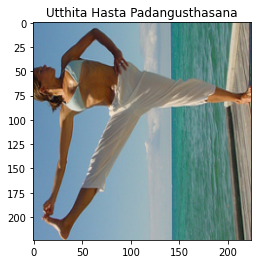

In [12]:
#View Sample Image
import matplotlib.pyplot as plt
img_sample = img.permute(2, 1, 0)
print(img.shape)
plt.imshow(img_sample)
plt.title(classes[label]);

#### Get Model


In [13]:
import torchvision
from torchvision import models
import torchvision.models.efficientnet as e
import torchvision.models.resnet as r

In [14]:
#Load Weights for Training
WEIGHTS = r.resnet50(pretrained= True)
WEIGHTS2 = e.efficientnet_b0(pretrained= True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-3dd342df.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-3dd342df.pth


  0%|          | 0.00/20.5M [00:00<?, ?B/s]

In [15]:
#View Resnet Details
WEIGHTS.state_dict

<bound method Module.state_dict of ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 2

In [16]:
##Freeze Model Params for Transfer Learning
for p in WEIGHTS.parameters():
    p.requires_grad = False

In [17]:
WEIGHTS.fc = nn.Linear(2048, classes_len)

In [18]:
#View Output Predictor
WEIGHTS.fc

Linear(in_features=2048, out_features=47, bias=True)

In [19]:
model = WEIGHTS
#Take model to device
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

#### Implement DataLoader

In [20]:
from torch.utils.data import DataLoader
BATCH_SIZE = 32
train_loader = DataLoader(dataset =train_set, batch_size =BATCH_SIZE, shuffle = True)
test_loader = DataLoader(dataset= valid_set, batch_size = BATCH_SIZE)

### Evaluation Metrics/ Loss Function / Optimizers


In [21]:
# Set up parameters
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr= 0.01)
accuracy_fn = Accuracy().to(device)
f1 = F1Score().to(device)

### Training and Evaluation

In [22]:
EPOCHS = 10

train_losses, train_acc = 0, 0

for epoch in range(EPOCHS):
  for batch, (X, y )in enumerate(train_loader):
    X = X.to(device)
    y = y.to(device)
    model.train()

    y_pred =model(X)
    loss = loss_fn(y_pred, y)
    train_acc += accuracy_fn(y_pred.argmax(dim=1), y)
    train_losses += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    if batch % 100 == 0:
      print(f'{train_losses} | {train_acc}')

  train_losses /= len(train_loader)
  train_acc /= len(train_loader)
  print(f' Train Loss: {train_losses:.4f} | Train Acc: {train_acc:.3f}')

model.eval()
test_loss, test_acc, test_f1 = 0, 0, 0
with torch.inference_mode():
    for Xt, yt in test_loader:
        Xt = Xt.to(device)
        yt= yt.to(device)
        test_pred = model(X)
        t_loss = loss_fn(test_pred, y)
        test_loss += t_loss
        test_acc += accuracy_fn(test_pred.argmax(dim=1), y)
        test_f1 += f1(test_pred.argmax(dim=1), y)
    test_loss /= len(test_loader)
    test_acc /= len(test_loader)
    test_f1 /= len(test_loader)
    
    print(f' Test Loss {test_loss:.4f} | Test Acc: {test_acc:.2f} | F1Score: {test_f1}  ')

3.9147307872772217 | 0.0


/opt/conda/lib/python3.7/site-packages/PIL/Image.py:993: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


 Train Loss: 7.6929 | Train Acc: 0.200
9.577621459960938 | 0.6370988488197327
 Train Loss: 1.8970 | Train Acc: 0.573
2.856748104095459 | 1.2292773723602295
 Train Loss: 1.4738 | Train Acc: 0.659
3.1654765605926514 | 1.3775465488433838
 Train Loss: 1.3559 | Train Acc: 0.692
2.5638880729675293 | 1.1919364929199219
 Train Loss: 0.9726 | Train Acc: 0.758
1.669601559638977 | 1.6953930854797363
 Train Loss: 0.9434 | Train Acc: 0.783
2.143364667892456 | 1.5017964839935303
 Train Loss: 0.8859 | Train Acc: 0.805
1.4611098766326904 | 1.6804090738296509
 Train Loss: 0.8935 | Train Acc: 0.813
1.6030595302581787 | 1.6566648483276367
 Train Loss: 0.6560 | Train Acc: 0.843
1.5593211650848389 | 1.4994237422943115
 Train Loss: 0.6192 | Train Acc: 0.860
 Test Loss 0.2927 | Test Acc: 0.89 | F1Score: 0.8928573727607727  


### Prediction with custom online image
link: https://images.everydayhealth.com/images/healthy-living/fitness/yoga-poses-for-beginners-03-722x406.jpg

In [23]:
!wget 'https://images.everydayhealth.com/images/healthy-living/fitness/yoga-poses-for-beginners-03-722x406.jpg'

--2022-09-05 15:33:51--  https://images.everydayhealth.com/images/healthy-living/fitness/yoga-poses-for-beginners-03-722x406.jpg
Resolving images.everydayhealth.com (images.everydayhealth.com)... 23.212.250.215, 23.212.250.200
Connecting to images.everydayhealth.com (images.everydayhealth.com)|23.212.250.215|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28867 (28K) [image/jpeg]
Saving to: ‘yoga-poses-for-beginners-03-722x406.jpg’

yoga-poses-for-begi 100%[===================>]  28.19K  --.-KB/s    in 0.08s   

2022-09-05 15:33:51 (338 KB/s) - ‘yoga-poses-for-beginners-03-722x406.jpg’ saved [28867/28867]



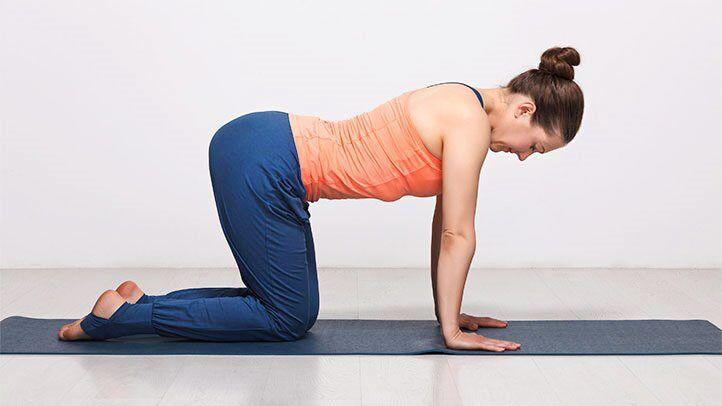

In [24]:
load_path = './yoga-poses-for-beginners-03-722x406.jpg'
from PIL import Image
img = Image.open(load_path)
img

In [25]:
transformed_img = transformer(img)

In [26]:
transformed_img = transformed_img.unsqueeze(dim=0)
transformed_img.shape

torch.Size([1, 3, 224, 224])

In [27]:
transformed_img.to(device)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [28]:
transformed_img = transformed_img.to(device)

In [29]:
transformed_img.device

device(type='cuda', index=0)

In [30]:
with torch.inference_mode():
    transformed_img.to(device)
    output = model(transformed_img)

In [31]:
outputp = torch.argmax(output).detach()
outputp =outputp.item()

In [32]:
Predicted_class = classes[outputp]
print(f'Predicted Class is: {Predicted_class} ')

Predicted Class is: Bitilasana 
